In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
import numpy as np
from sklearn.preprocessing import MinMaxScaler


from matplotlib.backends.backend_pdf import PdfPages
from google.colab import files
from pylab import rcParams
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Flatten
from keras.callbacks import EarlyStopping


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Functions

In [2]:
def create_dataset(dataset, look_back=1, response_variable_index=0, multi_feature = True):
  dataX, dataY = [], []
  if multi_feature :
    for i in range(len(dataset)-look_back-1):
      a = dataset[i:(i+look_back)]
      dataX.append(a)
      dataY.append(dataset[i + look_back, response_variable_index])
  else:
    for i in range(len(dataset)-look_back -1):
      a = dataset[i:(i+look_back-1),response_variable_index]
      dataX.append(a)
      dataY.append(dataset[i + look_back, response_variable_index])
  return np.array(dataX), np.array(dataY)

In [4]:
def prepare(df, scaling_range=(0,1),time_step=5,multi_feature=True, response_variable_index=0,data_split_ratio=0.8):
  df = df.astype("float32")
  scaler = MinMaxScaler(feature_range=scaling_range)
  dataset = scaler.fit_transform(df)
  X, Y = create_dataset(dataset, time_step, response_variable_index, multi_feature = True)
  # split into train and test sets
  train_size = int(len(dataset) * data_split_ratio)
  test_size = len(dataset) - train_size
  trainX, testX = X[0:train_size,:], X[train_size:len(dataset),:]
  trainY, testY = Y[0:train_size], Y[train_size:len(dataset)]
  #print(trainX.shape)
  #print(testX.shape)
  # reshape input to be [samples, time steps, features]
  if not multi_feature:
    trainX = np.reshape(trainX, (trainX.shape[0],trainX.shape[1],1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1],1))
    #print(trainX.shape)
  X_train=trainX
  X_test=testX
  y_train=trainY.reshape(-1,1)
  y_test=testY.reshape(-1,1)
  return X_train,X_test, y_train, y_test

In [5]:
def model_lstm():
  model_lstm = Sequential()
  model_lstm.add(LSTM(16, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
  model_lstm.add(LSTM(units=16))
  model_lstm.add(Dense(units=1))
  model_lstm.compile(loss='mae', optimizer='adam')
  return model_lstm
  #model_lstm.summary()

In [6]:
def model_gru():
  model_gru = Sequential()
  model_gru.add(GRU(16, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
  model_gru.add(GRU(units=16))
  model_gru.add(Dense(units=1))
  model_gru.compile(loss='mae', optimizer='adam')
  return model_gru

In [7]:
def model_mlp():
  model_mlp = Sequential()
  model_mlp.add(Flatten(input_shape = (X_train.shape[1], X_train.shape[2])))
  model_mlp.add(Dense(16, activation = "relu"))
  model_mlp.add(Dense(16, activation = "relu"))
  model_mlp.compile(loss='mae', optimizer='adam')
  return model_mlp

In [8]:
def fit(model, X_train, X_test, y_train, y_test):
  history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor= "val_loss", patience=10)], shuffle=False)
  return history


In [9]:
def predict(model, y_test):
  y_test_pre = model.predict(X_test)
  return y_test_pre

In [10]:
def visualize(y_test, y_pre, title):
  results = pd.DataFrame()
  #results['Date']= date_test.reset_index().Date.iloc[1:-1]
  #results["Date"] = date_test
  results["predicted"]=[i[0] for i in y_pre][1:] 
  results["true"] = y_test[:-1]
  #results = results.set_index(["Date"])
  #results.head()
  pyplot.plot(results["predicted"], label='predicted', color='red')
  pyplot.plot(results["true"], label='true', color= 'green')
  pyplot.legend()
  pyplot.title(title)
  pyplot.show()

In [11]:
def evaluate(y_test, y_pre):
  true = y_test[:-1]
  predicted = [i[0] for i in y_pre][1:]
  rmse = np.sqrt(mean_squared_error(true, predicted))
  mae = mean_absolute_error(true, predicted)
  #print(len(true))
  #print(len(predicted))
  return rmse, mae


#Import Data

In [12]:
# Maharashtra
df_Ma = pd.read_csv("https://raw.githubusercontent.com/sureshkuc/Data-Science-in-Life-Science-Project/main/Indian-States-Covid19-Datasets/Maharashtra.csv", parse_dates=["Date"]).drop(columns =["Unnamed: 0"])
# Karnataka
df_Ka = pd.read_csv("https://raw.githubusercontent.com/sureshkuc/Data-Science-in-Life-Science-Project/main/Indian-States-Covid19-Datasets/Karnataka.csv", parse_dates=["Date"]).drop(columns =["Unnamed: 0"])
# Kerala
df_Ke = pd.read_csv("https://raw.githubusercontent.com/sureshkuc/Data-Science-in-Life-Science-Project/main/Indian-States-Covid19-Datasets/Kerala.csv", parse_dates=["Date"]).drop(columns =["Unnamed: 0"])
# Tamil Nadu
df_TN = pd.read_csv("https://raw.githubusercontent.com/sureshkuc/Data-Science-in-Life-Science-Project/main/Indian-States-Covid19-Datasets/Tamil-Nadu.csv", parse_dates=["Date"]).drop(columns =["Unnamed: 0"])
# Uttar Pradesh
df_UP = pd.read_csv("https://raw.githubusercontent.com/sureshkuc/Data-Science-in-Life-Science-Project/main/Indian-States-Covid19-Datasets/Uttar-Pradesh.csv", parse_dates=["Date"]).drop(columns =["Unnamed: 0"])



In [13]:
df_Ma = df_Ma[["Date", "Confirmed", "Recovered", "Deceased", "New_Confirmerd", "New_Deaths", "New_Recovered"]]
df_Ka = df_Ka[["Date", "Confirmed", "Recovered", "Deceased", "New_Confirmerd", "New_Deaths", "New_Recovered"]]
df_Ke = df_Ke[["Date", "Confirmed", "Recovered", "Deceased", "New_Confirmerd", "New_Deaths", "New_Recovered"]]
df_TN = df_TN[["Date", "Confirmed", "Recovered", "Deceased", "New_Confirmerd", "New_Deaths", "New_Recovered"]]
df_UP = df_UP[["Date", "Confirmed", "Recovered", "Deceased", "New_Confirmerd", "New_Deaths", "New_Recovered"]]

In [14]:
df_Ma = df_Ma[df_Ma["Date"] > "2020-03-09"]
df_Ka = df_Ka[df_Ka["Date"] > "2020-03-09"]
df_Ke = df_Ke[df_Ke["Date"] > "2020-03-09"]
df_TN = df_TN[df_TN["Date"] > "2020-03-09"]
df_UP = df_UP[df_UP["Date"] > "2020-03-09"]

In [16]:
df_Ma.tail()

,Date,Confirmed,Recovered,Deceased,New_Confirmerd,New_Deaths,New_Recovered
473,2021-06-25,6017035,5772799,120370,9604.0,511.0,10138.0
474,2021-06-26,6026847,5781551,120881,9812.0,511.0,8752.0
475,2021-06-27,6036821,5790113,121286,9974.0,405.0,8562.0
476,2021-06-28,6043548,5800925,121573,6727.0,287.0,10812.0
477,2021-06-29,6043548,5800925,121573,0.0,0.0,0.0


In [ ]:
df_Ma = df_Ma.set_index("Date")
df_Ka = df_Ka.set_index("Date")
df_Ke = df_Ke.set_index("Date")
df_TN = df_TN.set_index("Date")
df_UP = df_UP.set_index("Date")


In [ ]:
RMSE_lstm = []
MAE_lstm = []
RMSE_gru = []
MAE_gru = []
RMSE_mlp = []
MAE_mlp = []
states = ["Maharashtra", "Karnataka", "Kerala", "Tamil Nadu", "Uttar Pradesh"]

# Maharashtra

In [ ]:
X_train,X_test, y_train, y_test = prepare(df_Ma, scaling_range=(0,1),time_step=5,multi_feature=True, response_variable_index=0,data_split_ratio=0.8)

In [ ]:
print("X_train.shape", X_train.shape)
print("X_test.shape", X_test.shape)
print("y_train.shape", y_train.shape)
print("y_test.shape", y_test.shape)

X_train.shape (381, 5, 6)
X_test.shape (90, 5, 6)
y_train.shape (381, 1)
y_test.shape (90, 1)


In [ ]:
model_MLP = model_mlp()
fit(model_MLP, X_train, X_test, y_train, y_test)

Epoch 1/100
24/24 [==============================] - 1s 12ms/step - loss: 0.0636 - val_loss: 0.5326
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0508 - val_loss: 0.4548
Epoch 3/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0452 - val_loss: 0.4054
Epoch 4/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.3648
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0372 - val_loss: 0.3596
Epoch 6/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.3572
Epoch 7/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0319 - val_loss: 0.3539
Epoch 8/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0311 - val_loss: 0.3447
Epoch 9/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0300 - val_loss: 0.3467
Epoch 10/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0308 - val_loss: 0.3351
Epoch 11

In [ ]:
model_MLP.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 30)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 16)                496       
_________________________________________________________________
dense_21 (Dense)             (None, 16)                272       
Total params: 768
Trainable params: 768
Non-trainable params: 0
_________________________________________________________________


MLP RESULTS
RMSE =  0.8315616
MAE =  0.81427824


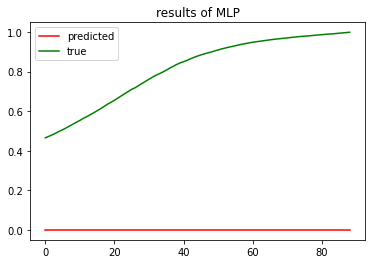

In [ ]:
y_test_pre_mlp = predict(model_MLP, y_test)
print("MLP RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_mlp)
RMSE_mlp.append(rmse)
MAE_mlp.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_mlp, "results of MLP")

In [ ]:
model_LSTM = model_lstm()
fit(model_LSTM, X_train, X_test, y_train, y_test)

Epoch 1/100
24/24 [==============================] - 5s 54ms/step - loss: 0.0572 - val_loss: 0.6225
Epoch 2/100
24/24 [==============================] - 0s 8ms/step - loss: 0.1078 - val_loss: 0.4683
Epoch 3/100
24/24 [==============================] - 0s 8ms/step - loss: 0.1196 - val_loss: 0.2233
Epoch 4/100
24/24 [==============================] - 0s 7ms/step - loss: 0.1319 - val_loss: 0.2007
Epoch 5/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0706 - val_loss: 0.1485
Epoch 6/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0378 - val_loss: 0.1180
Epoch 7/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0086 - val_loss: 0.0838
Epoch 8/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0597 - val_loss: 0.1377
Epoch 9/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0198 - val_loss: 0.1285
Epoch 10/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0183 - val_loss: 0.0859
Epoch 11

In [ ]:
model_LSTM.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 5, 16)             1472      
_________________________________________________________________
lstm_11 (LSTM)               (None, 16)                2112      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 17        
Total params: 3,601
Trainable params: 3,601
Non-trainable params: 0
_________________________________________________________________


LSTM RESULTS
RMSE =  0.25415742
MAE =  0.21389021


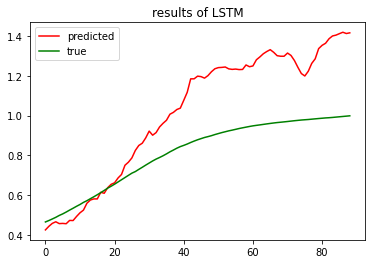

In [ ]:
y_test_pre_lstm = predict(model_LSTM, y_test)
print("LSTM RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_lstm)
RMSE_lstm.append(rmse)
MAE_lstm.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_lstm, "results of LSTM")


In [ ]:
model_GRU = model_gru()
fit(model_GRU, X_train, X_test, y_train, y_test)

Epoch 1/100
24/24 [==============================] - 5s 56ms/step - loss: 0.0770 - val_loss: 0.6704
Epoch 2/100
24/24 [==============================] - 0s 8ms/step - loss: 0.1443 - val_loss: 0.4774
Epoch 3/100
24/24 [==============================] - 0s 9ms/step - loss: 0.1545 - val_loss: 0.3063
Epoch 4/100
24/24 [==============================] - 0s 9ms/step - loss: 0.1552 - val_loss: 0.2710
Epoch 5/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0832 - val_loss: 0.2583
Epoch 6/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0370 - val_loss: 0.1978
Epoch 7/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0343 - val_loss: 0.1370
Epoch 8/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0296 - val_loss: 0.1013
Epoch 9/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0108 - val_loss: 0.0755
Epoch 10/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0127 - val_loss: 0.1070
Epoch 11

In [ ]:
model_GRU.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_10 (GRU)                 (None, 5, 16)             1152      
_________________________________________________________________
gru_11 (GRU)                 (None, 16)                1632      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 17        
Total params: 2,801
Trainable params: 2,801
Non-trainable params: 0
_________________________________________________________________


GRU RESULTS
RMSE =  0.07357706
MAE =  0.069679424


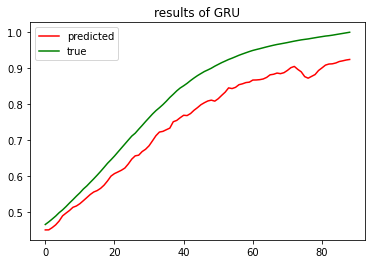

In [ ]:
y_test_pre_gru = predict(model_GRU, y_test)
print("GRU RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_gru)
RMSE_gru.append(rmse)
MAE_gru.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_gru, "results of GRU")



# Karnataka


In [ ]:
X_train,X_test, y_train, y_test = prepare(df_Ka, scaling_range=(0,1),time_step=5,multi_feature=True, response_variable_index=0,data_split_ratio=0.8)

In [ ]:
model_MLP = model_mlp()
fit(model_MLP, X_train, X_test, y_train, y_test)

Epoch 1/100
24/24 [==============================] - 1s 11ms/step - loss: 0.0529 - val_loss: 0.5025
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0496 - val_loss: 0.4664
Epoch 3/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.4112
Epoch 4/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0416 - val_loss: 0.3634
Epoch 5/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.3255
Epoch 6/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0346 - val_loss: 0.3002
Epoch 7/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0313 - val_loss: 0.2897
Epoch 8/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.2762
Epoch 9/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0267 - val_loss: 0.2659
Epoch 10/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0238 - val_loss: 0.2516
Epoch 11

MLP RESULTS
RMSE =  0.20465636
MAE =  0.17444712


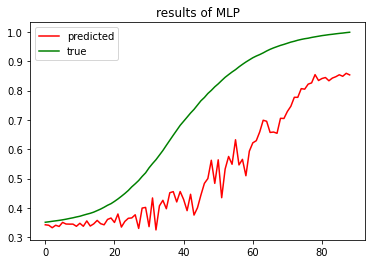

In [ ]:
y_test_pre_mlp = predict(model_MLP, y_test)
print("MLP RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_mlp)
RMSE_mlp.append(rmse)
MAE_mlp.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_mlp, "results of MLP")

In [ ]:
model_LSTM = model_lstm()
fit(model_LSTM, X_train, X_test, y_train, y_test)

Epoch 1/100
24/24 [==============================] - 5s 52ms/step - loss: 0.0532 - val_loss: 0.5115
Epoch 2/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0887 - val_loss: 0.3256
Epoch 3/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0993 - val_loss: 0.0564
Epoch 4/100
24/24 [==============================] - 0s 7ms/step - loss: 0.1069 - val_loss: 0.1018
Epoch 5/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0382 - val_loss: 0.1486
Epoch 6/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0057 - val_loss: 0.1590
Epoch 7/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0210 - val_loss: 0.1191
Epoch 8/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0302 - val_loss: 0.1330
Epoch 9/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0226 - val_loss: 0.1609
Epoch 10/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0189 - val_loss: 0.1564
Epoch 11

LSTM RESULTS
RMSE =  0.15901573
MAE =  0.137007


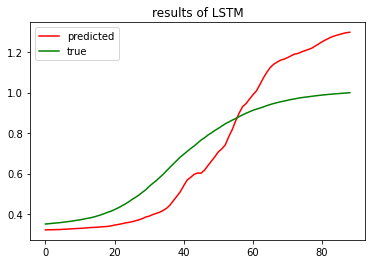

In [ ]:
y_test_pre_lstm = predict(model_LSTM, y_test)
print("LSTM RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_lstm)
RMSE_lstm.append(rmse)
MAE_lstm.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_lstm, "results of LSTM")

In [ ]:
model_GRU = model_gru()
fit(model_GRU, X_train, X_test, y_train, y_test)

Epoch 1/100
24/24 [==============================] - 5s 54ms/step - loss: 0.0638 - val_loss: 0.5291
Epoch 2/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0973 - val_loss: 0.2720
Epoch 3/100
24/24 [==============================] - 0s 8ms/step - loss: 0.1167 - val_loss: 0.2052
Epoch 4/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0664 - val_loss: 0.1584
Epoch 5/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0344 - val_loss: 0.0738
Epoch 6/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0180 - val_loss: 0.0555
Epoch 7/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0144 - val_loss: 0.0619
Epoch 8/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0040 - val_loss: 0.0948
Epoch 9/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0109 - val_loss: 0.0883
Epoch 10/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0063 - val_loss: 0.0576
Epoch 11

GRU RESULTS
RMSE =  0.020455832
MAE =  0.015903559


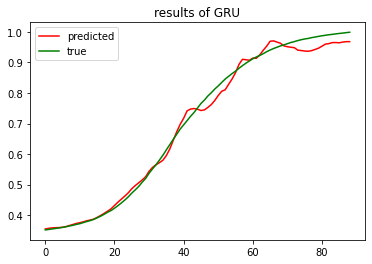

In [ ]:
y_test_pre_gru = predict(model_GRU, y_test)
print("GRU RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_gru)
RMSE_gru.append(rmse)
MAE_gru.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_gru, "results of GRU")


# Kerala

In [ ]:
X_train,X_test, y_train, y_test = prepare(df_Ke, scaling_range=(0,1),time_step=5,multi_feature=True, response_variable_index=0,data_split_ratio=0.8)

In [ ]:
model_MLP = model_mlp()
fit(model_MLP, X_train, X_test, y_train, y_test)

Epoch 1/100
24/24 [==============================] - 1s 11ms/step - loss: 0.0311 - val_loss: 0.5144
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0275 - val_loss: 0.4374
Epoch 3/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0256 - val_loss: 0.3794
Epoch 4/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0234 - val_loss: 0.3676
Epoch 5/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0202 - val_loss: 0.3246
Epoch 6/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0179 - val_loss: 0.3089
Epoch 7/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0171 - val_loss: 0.2806
Epoch 8/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0148 - val_loss: 0.2744
Epoch 9/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0140 - val_loss: 0.2503
Epoch 10/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0127 - val_loss: 0.2484
Epoch 11

MLP RESULTS
RMSE =  0.04576023
MAE =  0.037774485


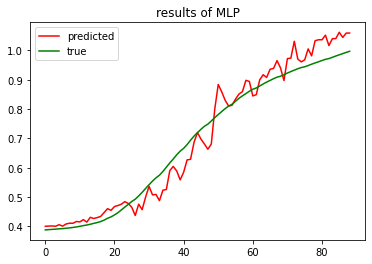

In [ ]:
y_test_pre_mlp = predict(model_MLP, y_test)
print("MLP RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_mlp)
RMSE_mlp.append(rmse)
MAE_mlp.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_mlp, "results of MLP")

In [ ]:
model_LSTM = model_lstm()
fit(model_LSTM, X_train, X_test, y_train, y_test)

Epoch 1/100
24/24 [==============================] - 6s 68ms/step - loss: 0.0363 - val_loss: 0.6499
Epoch 2/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0664 - val_loss: 0.5997
Epoch 3/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0670 - val_loss: 0.5327
Epoch 4/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0615 - val_loss: 0.3551
Epoch 5/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0492 - val_loss: 0.1665
Epoch 6/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0424 - val_loss: 0.2174
Epoch 7/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0516 - val_loss: 0.3000
Epoch 8/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0165 - val_loss: 0.2136
Epoch 9/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0091 - val_loss: 0.2241
Epoch 10/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0091 - val_loss: 0.2314
Epo

LSTM RESULTS
RMSE =  0.29180294
MAE =  0.24369742


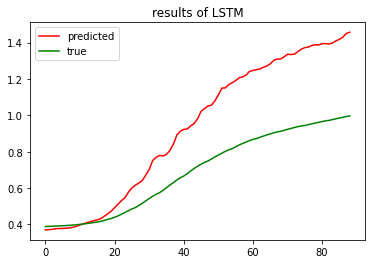

In [ ]:
y_test_pre_lstm = predict(model_LSTM, y_test)
print("LSTM RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_lstm)
RMSE_lstm.append(rmse)
MAE_lstm.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_lstm, "results of LSTM")

In [ ]:
model_GRU = model_gru()
fit(model_GRU, X_train, X_test, y_train, y_test)

Epoch 1/100
24/24 [==============================] - 6s 53ms/step - loss: 0.0320 - val_loss: 0.5130
Epoch 2/100
24/24 [==============================] - 0s 8ms/step - loss: 0.1305 - val_loss: 0.3880
Epoch 3/100
24/24 [==============================] - 0s 9ms/step - loss: 0.1079 - val_loss: 0.2450
Epoch 4/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0710 - val_loss: 0.0638
Epoch 5/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0398 - val_loss: 0.2478
Epoch 6/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0383 - val_loss: 0.1392
Epoch 7/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0265 - val_loss: 0.0496
Epoch 8/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0736 - val_loss: 0.0961
Epoch 9/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0375 - val_loss: 0.1635
Epoch 10/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0140 - val_loss: 0.1535
Epoch 11

GRU RESULTS
RMSE =  0.15460803
MAE =  0.11973623


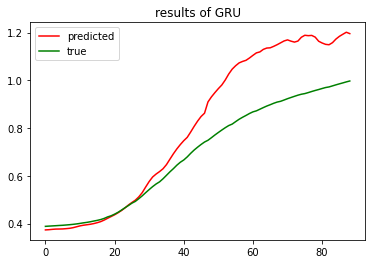

In [ ]:
y_test_pre_gru = predict(model_GRU, y_test)
print("GRU RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_gru)
RMSE_gru.append(rmse)
MAE_gru.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_gru, "results of GRU")


# Tamil Nadu



In [ ]:
X_train,X_test, y_train, y_test = prepare(df_TN, scaling_range=(0,1),time_step=5,multi_feature=True, response_variable_index=0,data_split_ratio=0.8)

In [ ]:
model_MLP = model_mlp()
fit(model_MLP, X_train, X_test, y_train, y_test)

Epoch 1/100
24/24 [==============================] - 1s 13ms/step - loss: 0.0557 - val_loss: 0.3855
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0566 - val_loss: 0.3443
Epoch 3/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0518 - val_loss: 0.3118
Epoch 4/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.2695
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0372 - val_loss: 0.2110
Epoch 6/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0345 - val_loss: 0.2044
Epoch 7/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0305 - val_loss: 0.2008
Epoch 8/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.2075
Epoch 9/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.2108
Epoch 10/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0239 - val_loss: 0.1915
Epoch 11

MLP RESULTS
RMSE =  0.19514075
MAE =  0.15956987


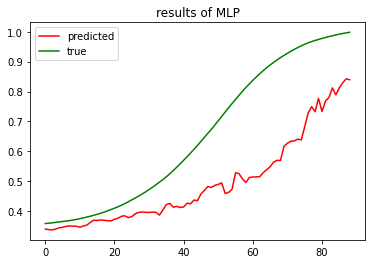

In [ ]:
y_test_pre_mlp = predict(model_MLP, y_test)
print("MLP RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_mlp)
RMSE_mlp.append(rmse)
MAE_mlp.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_mlp, "results of MLP")

In [ ]:
model_LSTM = model_lstm()
fit(model_LSTM, X_train, X_test, y_train, y_test)

Epoch 1/100
24/24 [==============================] - 5s 47ms/step - loss: 0.0856 - val_loss: 0.5802
Epoch 2/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0799 - val_loss: 0.3440
Epoch 3/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0937 - val_loss: 0.0886
Epoch 4/100
24/24 [==============================] - 0s 8ms/step - loss: 0.1186 - val_loss: 0.1617
Epoch 5/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0492 - val_loss: 0.1100
Epoch 6/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0275 - val_loss: 0.0939
Epoch 7/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0141 - val_loss: 0.1095
Epoch 8/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0121 - val_loss: 0.1071
Epoch 9/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0159 - val_loss: 0.1287
Epoch 10/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0056 - val_loss: 0.1659
Epoch 11

LSTM RESULTS
RMSE =  0.079083405
MAE =  0.069167435


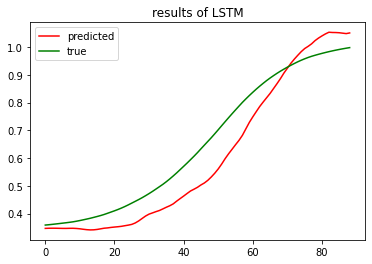

In [ ]:
y_test_pre_lstm = predict(model_LSTM, y_test)
print("LSTM RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_lstm)
RMSE_lstm.append(rmse)
MAE_lstm.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_lstm, "results of LSTM")

In [ ]:
model_GRU = model_gru()
fit(model_GRU, X_train, X_test, y_train, y_test)

Epoch 1/100
24/24 [==============================] - 5s 48ms/step - loss: 0.0621 - val_loss: 0.3156
Epoch 2/100
24/24 [==============================] - 0s 7ms/step - loss: 0.1326 - val_loss: 0.2212
Epoch 3/100
24/24 [==============================] - 0s 7ms/step - loss: 0.1186 - val_loss: 0.2459
Epoch 4/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0673 - val_loss: 0.3441
Epoch 5/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0350 - val_loss: 0.2423
Epoch 6/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0378 - val_loss: 0.0843
Epoch 7/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0446 - val_loss: 0.0966
Epoch 8/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0132 - val_loss: 0.0487
Epoch 9/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0239 - val_loss: 0.0542
Epoch 10/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0174 - val_loss: 0.0725
Epoch 11

GRU RESULTS
RMSE =  0.10811183
MAE =  0.09271281


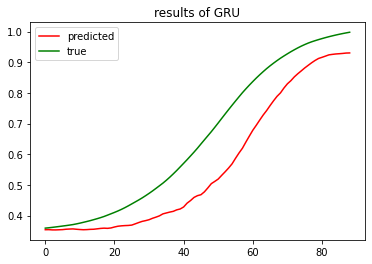

In [ ]:
y_test_pre_gru = predict(model_GRU, y_test)
print("GRU RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_gru)
RMSE_gru.append(rmse)
MAE_gru.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_gru, "results of GRU")


# Uttar Pradesh

In [ ]:
X_train,X_test, y_train, y_test = prepare(df_UP, scaling_range=(0,1),time_step=5,multi_feature=True, response_variable_index=0,data_split_ratio=0.8)

In [ ]:
model_MLP = model_mlp()
fit(model_MLP, X_train, X_test, y_train, y_test)

Epoch 1/100
24/24 [==============================] - 1s 13ms/step - loss: 0.0433 - val_loss: 0.4240
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0381 - val_loss: 0.3025
Epoch 3/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0348 - val_loss: 0.2739
Epoch 4/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.2157
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0242 - val_loss: 0.1887
Epoch 6/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0177 - val_loss: 0.1588
Epoch 7/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0152 - val_loss: 0.1469
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0119 - val_loss: 0.1342
Epoch 9/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0113 - val_loss: 0.1213
Epoch 10/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0106 - val_loss: 0.1331
Epoch 11

MLP RESULTS
RMSE =  0.060962602
MAE =  0.050484587


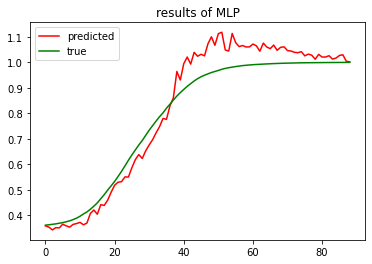

In [ ]:
y_test_pre_mlp = predict(model_MLP, y_test)
print("MLP RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_mlp)
RMSE_mlp.append(rmse)
MAE_mlp.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_mlp, "results of MLP")

In [ ]:
model_LSTM = model_lstm()
fit(model_LSTM, X_train, X_test, y_train, y_test)

Epoch 1/100
24/24 [==============================] - 5s 49ms/step - loss: 0.0519 - val_loss: 0.5337
Epoch 2/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0927 - val_loss: 0.2915
Epoch 3/100
24/24 [==============================] - 0s 7ms/step - loss: 0.1099 - val_loss: 0.2427
Epoch 4/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0784 - val_loss: 0.1560
Epoch 5/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0591 - val_loss: 0.1494
Epoch 6/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0374 - val_loss: 0.0857
Epoch 7/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0281 - val_loss: 0.1113
Epoch 8/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0157 - val_loss: 0.1470
Epoch 9/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0082 - val_loss: 0.2756
Epoch 10/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0117 - val_loss: 0.2597
Epoch 11

LSTM RESULTS
RMSE =  0.18546656
MAE =  0.1613141


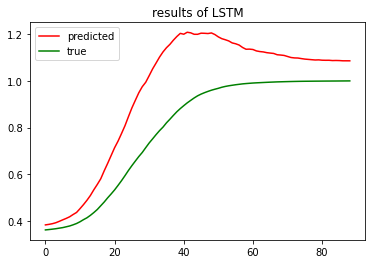

In [ ]:
y_test_pre_lstm = predict(model_LSTM, y_test)
print("LSTM RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_lstm)
RMSE_lstm.append(rmse)
MAE_lstm.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_lstm, "results of LSTM")

In [ ]:
model_GRU = model_gru()
fit(model_GRU, X_train, X_test, y_train, y_test)

Epoch 1/100
24/24 [==============================] - 5s 51ms/step - loss: 0.0443 - val_loss: 0.2594
Epoch 2/100
24/24 [==============================] - 0s 9ms/step - loss: 0.1344 - val_loss: 0.1401
Epoch 3/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0981 - val_loss: 0.0727
Epoch 4/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0516 - val_loss: 0.0207
Epoch 5/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0057 - val_loss: 0.0297
Epoch 6/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0120 - val_loss: 0.0565
Epoch 7/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0282 - val_loss: 0.0611
Epoch 8/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0104 - val_loss: 0.0413
Epoch 9/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0096 - val_loss: 0.0273
Epoch 10/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0117 - val_loss: 0.0359
Epoch 1

GRU RESULTS
RMSE =  0.068189554
MAE =  0.055727705


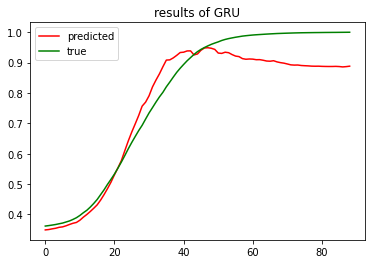

In [ ]:
y_test_pre_gru = predict(model_GRU, y_test)
print("GRU RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_gru)
RMSE_gru.append(rmse)
MAE_gru.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_gru, "results of GRU")


# Comparison

In [ ]:
MAE_cnn = [0.0765, 0.1056, 0.1014, 0.1084, 0.0552]
RMSE_cnn = [0.0864, 0.1543, 0.1347, 0.1418, 0.0738]

In [ ]:
compare = pd.DataFrame()
compare["State"] = states
compare["rmse_mlp"] = RMSE_mlp
compare["rmse_lstm"] = RMSE_lstm
compare["rmse_gru"] = RMSE_gru
compare["rmse_cnn"] = RMSE_cnn
compare["mae_mlp"] = MAE_mlp
compare["mae_lstm"] = MAE_lstm
compare["mae_gru"] = MAE_gru
compare["mae_cnn"] = MAE_cnn


In [ ]:
compare = compare.round(4)
compare.head()

,State,rmse_mlp,rmse_lstm,rmse_gru,rmse_cnn,mae_mlp,mae_lstm,mae_gru,mae_cnn
0,Maharashtra,0.8316,0.2542,0.0736,0.0864,0.8143,0.2139,0.0697,0.0765
1,Karnataka,0.2047,0.1590,0.0205,0.1543,0.1744,0.1370,0.0159,0.1056
2,Kerala,0.0458,0.2918,0.1546,0.1347,0.0378,0.2437,0.1197,0.1014
3,Tamil Nadu,0.1951,0.0791,0.1081,0.1418,0.1596,0.0692,0.0927,0.1084
4,Uttar Pradesh,0.0610,0.1855,0.0682,0.0738,0.0505,0.1613,0.0557,0.0552


In [ ]:
compare[["rmse_mlp",	"rmse_lstm",	"rmse_gru",	"rmse_cnn"]].mean(axis = 0)

rmse_mlp     0.26764
rmse_lstm    0.19392
rmse_gru     0.08500
rmse_cnn     0.11820
dtype: float64

In [ ]:
compare[["mae_mlp",	"mae_lstm",	"mae_gru",	"mae_cnn"]].mean(axis = 0)

mae_mlp     0.24732
mae_lstm    0.16502
mae_gru     0.07074
mae_cnn     0.08942
dtype: float64

# RMSE Radar Chart

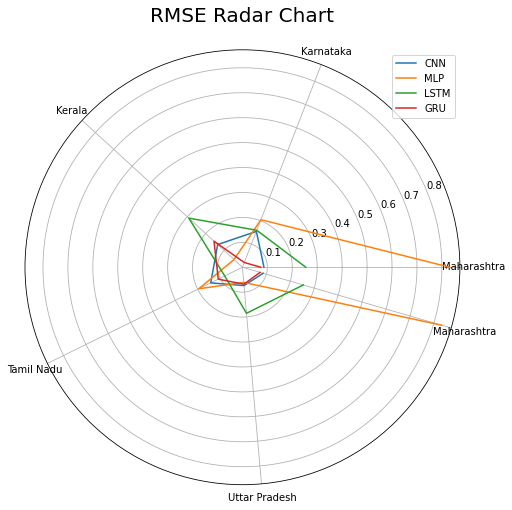

In [ ]:
categories = states
categories = [*categories, categories[0]]

CNN = RMSE_cnn
MLP = RMSE_mlp
LSTM = RMSE_lstm
GRU = RMSE_gru
CNN = [*CNN, CNN[0]]
MLP = [*MLP, MLP[0]]
LSTM = [*LSTM, LSTM[0]]
GRU = [*GRU, GRU[0]]

label_loc = np.linspace(start=0, stop=6, num=len(CNN))

plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, CNN, label='CNN')
plt.plot(label_loc, MLP, label='MLP')
plt.plot(label_loc, LSTM, label='LSTM')
plt.plot(label_loc, GRU, label='GRU')
plt.title('RMSE Radar Chart', size=20, y=1.05)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()
plt.show()

# MAE Radar Chart

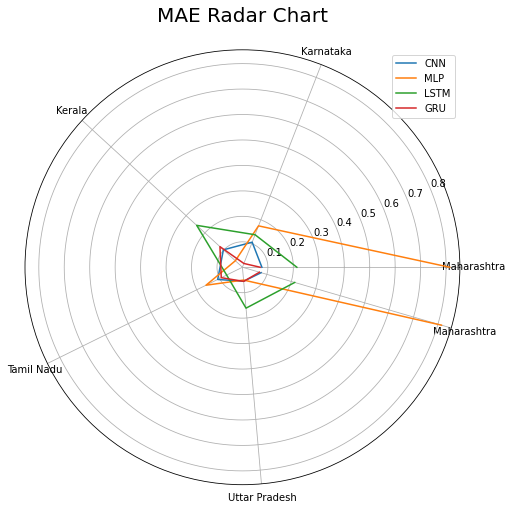

In [ ]:
CNN = MAE_cnn
MLP = MAE_mlp
LSTM = MAE_lstm
GRU = MAE_gru
CNN = [*CNN, CNN[0]]
MLP = [*MLP, MLP[0]]
LSTM = [*LSTM, LSTM[0]]
GRU = [*GRU, GRU[0]]

label_loc = np.linspace(start=0, stop=6, num=len(CNN))

plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, CNN, label='CNN')
plt.plot(label_loc, MLP, label='MLP')
plt.plot(label_loc, LSTM, label='LSTM')
plt.plot(label_loc, GRU, label='GRU')
plt.title('MAE Radar Chart', size=20, y=1.05)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()
plt.show()